In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df=pd.read_csv("/content/BERGERPBL.csv",parse_dates=['DATE'])
df.head()

#       DATE TRADING CODE    LTP*  ...     YCP   TRADE  VALUE (mn)   VOLUME
0  439 2018-05-08    BERGERPBL  1265.0  ...  1275.4   256.0        4.60   3610.0
1  438 2018-06-08    BERGERPBL  1285.0  ...  1265.3   222.0        6.02   4735.0
2  437 2018-07-08    BERGERPBL  1244.0  ...  1277.5  1958.0       84.90  68318.0
3  436 2018-08-08    BERGERPBL  1215.0  ...  1235.2  1729.0       49.76  41094.0
4  435 2018-09-08    BERGERPBL  1194.7  ...  1210.4  1276.0       24.90  20785.0

[5 rows x 12 columns]

In [ ]:
# Sort DataFrame by date
df = df.sort_values('DATE')

# Double check the result
df.head()

#       DATE TRADING CODE    LTP*  ...     YCP   TRADE  VALUE (mn)   VOLUME
36  403 2018-01-10    BERGERPBL  1250.4  ...  1250.6   552.0       11.42   9109.0
59  380 2018-01-11    BERGERPBL  1222.1  ...  1228.4   324.0        4.08   3331.0
37  402 2018-02-10    BERGERPBL  1246.1  ...  1252.2   422.0        6.19   4950.0
79  360 2018-02-12    BERGERPBL  1355.0  ...  1387.7  1472.0       44.18  31926.0
16  423 2018-03-09    BERGERPBL  1253.0  ...  1268.2   781.0       21.22  16700.0

[5 rows x 12 columns]

In [ ]:
df = df.set_index('DATE')
df.head(3)

# TRADING CODE    LTP*    HIGH  ...     YCP  TRADE  VALUE (mn)  VOLUME
DATE                                          ...                                   
2018-01-10  403    BERGERPBL  1250.4  1278.9  ...  1250.6  552.0       11.42  9109.0
2018-01-11  380    BERGERPBL  1222.1  1234.0  ...  1228.4  324.0        4.08  3331.0
2018-02-10  402    BERGERPBL  1246.1  1268.0  ...  1252.2  422.0        6.19  4950.0

[3 rows x 11 columns]

In [ ]:
df['daily_ret'] = df['CLOSEP*'].pct_change()
df['daily_ret'] = df['daily_ret'].fillna(0.0)

In [ ]:
df['volatility']= df['daily_ret'].rolling(window=21).std()
df['volatility'] = df['volatility'].fillna(0.0)

In [ ]:
df['volatility'] = df['volatility']*100

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
df=df.reset_index()['volatility']

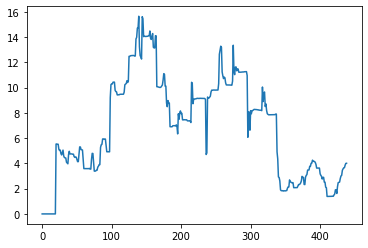

In [ ]:
plt.plot(df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
df.shape

(439, 1)

In [ ]:
##splitting dataset into train and test split where train=70 percent and test=30 percent
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]




In [ ]:

training_size,test_size

(307, 132)

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:

print(X_train.shape), print(y_train.shape)

(206, 100)
(206,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
from keras.optimizers import Adam

In [ ]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
7/7 [==============================] - 6s 328ms/step - loss: 0.3045 - val_loss: 0.0390
Epoch 2/100
7/7 [==============================] - 1s 141ms/step - loss: 0.0452 - val_loss: 0.0183
Epoch 3/100
7/7 [==============================] - 1s 152ms/step - loss: 0.0279 - val_loss: 0.0277
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0145 - val_loss: 0.0526
Epoch 5/100
7/7 [==============================] - 1s 138ms/step - loss: 0.0140 - val_loss: 0.0312
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 0.0142 - val_loss: 0.0391
Epoch 7/100
7/7 [==============================] - 1s 136ms/step - loss: 0.0132 - val_loss: 0.0434
Epoch 8/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0113 - val_loss: 0.0326
Epoch 9/100
7/7 [==============================] - 1s 147ms/step - loss: 0.0128 - val_loss: 0.0414
Epoch 10/100
7/7 [==============================] - 1s 154ms/step - loss: 0.0135 - val_loss: 0.0333
Epoch 11/

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

 Aggression_detection
 annotation
 Annotation-data
 assignment
 assignment1.zip
 assignment.ipynb
 assignment_ML
 assignment_shapna.zip
'BANGLA OCR'
 Classroom
 CNN
'Colab Notebooks'
 conference-template-a4.docx
 consent_form_1721568042.docx
'consent form.docx'
'Cooking vlog-shapna '
 deeplearning
'DevOps Engineer.jpg'
 Diabetes_prediction
'dogs-vs-cats '
'ECO Lecture -3.gdoc'
'emu8086.zip (Unzipped Files)'
 finalExam_cse445.docx
 FinalExam_mst.shapna-akter_1721568042.docx
 finalNepal.xls
 finalreport.rtf
 full_traindata.zip
 FUwangfood.ipynb
'Getting started.pdf'
'housing price prediction'
 housingPrice_testDataHandle.ipynb
 implementation_LSTM
 LAB2_1721568042.zip
 LAB4_1721568042.zip
 labeledTrainData.tsv
 mask
'mid -missing part.pdf'
 midterm_1721568042.docx
 midterm_ML
 ML_midterm_1721568042.docx
 ModelFile.zip
'mst shapna akter_1721568042.docx'
 mst_shapna_akter_1721568042.docx
 mst.shapna-akter_1721568042.docx
'mst shapna akter-1721568042-sec09.pdf'
 mst.shapna-akter_1721568042.

In [ ]:
filepath = "/content/drive/MyDrive/stock price_LSTM/modelsBERGERPBL/model.h5"
model.save(filepath)
from keras.models import load_model
f1 = '/content/drive/MyDrive/stock price_LSTM/modelsBERGERPBL/model.h5'
model = load_model(f1)

In [ ]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [ ]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
X = np.reshape(ytest,(1, ytest.size))
Y_test =scaler.inverse_transform(X)

In [ ]:
Y_test = Y_test.transpose()
RMSE = math.sqrt(mean_squared_error(Y_test,test_predict))
RMSE

5.460531539584355

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test,test_predict)
print('MAE: %f' % mae)

MAE: 5.397243


In [ ]:
Y_test

array([[2.51368837],
       [2.11558746],
       [2.07551226],
       [1.38372562],
       [1.38372562],
       [1.38372562],
       [1.38372562],
       [1.38372562],
       [1.38372562],
       [1.39126503],
       [1.39986198],
       [1.39986198],
       [1.39986198],
       [1.50335943],
       [1.57719186],
       [1.90821559],
       [1.90821559],
       [1.61726801],
       [2.15445503],
       [2.47684157],
       [2.49513074],
       [2.51708613],
       [2.79752762],
       [3.00037658],
       [3.05021567],
       [3.4470819 ],
       [3.56497017],
       [3.64432578],
       [3.65854508],
       [3.86230258],
       [3.99987419]])

In [ ]:
test_predict

array([[7.7885523],
       [7.787449 ],
       [7.782048 ],
       [7.7723193],
       [7.754654 ],
       [7.7295856],
       [7.6998672],
       [7.668326 ],
       [7.6371026],
       [7.607509 ],
       [7.5801754],
       [7.5561647],
       [7.5336123],
       [7.5129843],
       [7.4942193],
       [7.4770813],
       [7.4641986],
       [7.4551682],
       [7.4465904],
       [7.44059  ],
       [7.440027 ],
       [7.4445877],
       [7.452521 ],
       [7.463998 ],
       [7.479437 ],
       [7.497853 ],
       [7.5206056],
       [7.547598 ],
       [7.5775547],
       [7.6085453],
       [7.6403904]], dtype=float32)

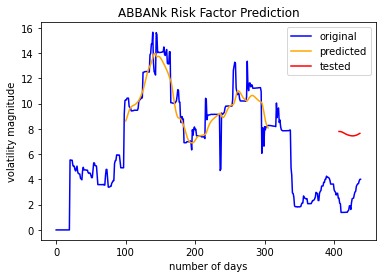

In [ ]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df),color ='blue', label ='original')
plt.plot(trainPredictPlot, color ='orange', label ='predicted')
plt.plot(testPredictPlot , color ='red', label ='tested')
#plt.show()
plt.xlabel('number of days')
plt.ylabel('volatility magnitude')
plt.title('ABBANk Risk Factor Prediction')
plt.legend(loc='best')
plt.show(block=False)


In [ ]:

x_input=test_data[32:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)


[0.4926456]
101
1 day input [0.18689288 0.18445392 0.16680529 0.12206492 0.11749496 0.11742412
 0.11743339 0.1155643  0.11715316 0.11665896 0.11644926 0.11759387
 0.11812569 0.13015938 0.13650953 0.13644255 0.17196616 0.16236118
 0.16075942 0.15777486 0.15811726 0.15778135 0.13273937 0.1327303
 0.13285964 0.13289167 0.1330764  0.13307687 0.14113676 0.14852417
 0.14853905 0.15132203 0.15692189 0.16727421 0.18990514 0.18474313
 0.18474313 0.14913688 0.14839946 0.18619121 0.19476182 0.19920616
 0.22173264 0.2221687  0.22237572 0.24043558 0.24045993 0.25578009
 0.25670301 0.27186093 0.26609566 0.26609721 0.26499241 0.26055014
 0.25049654 0.2319417  0.23192623 0.23192623 0.23192623 0.23192623
 0.20305829 0.19527556 0.18999592 0.17646827 0.18511035 0.18508104
 0.16070731 0.16070731 0.13525558 0.13269346 0.08846555 0.08846555
 0.08846555 0.08846555 0.08846555 0.08846555 0.08894757 0.0894972
 0.0894972  0.0894972  0.09611408 0.1008344  0.1219977  0.1219977
 0.10339659 0.13774049 0.15835159 0.1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

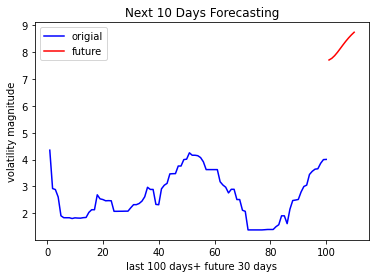

In [ ]:

plt.plot(day_new,scaler.inverse_transform(df[339:]),color ='blue', label ='origial')
plt.plot(day_pred,scaler.inverse_transform(lst_output),color='red', label='future')
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 10 Days Forecasting')
plt.legend(loc='best')
plt.show(block=False)

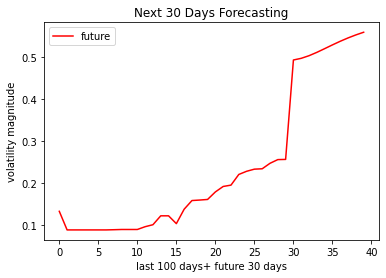

In [ ]:
df3=df.tolist()
df3.extend(lst_output)
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 30 Days Forecasting')
plt.plot(df3[409:],color='red', label='future')
plt.legend(loc='best')
plt.show(block=False)

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

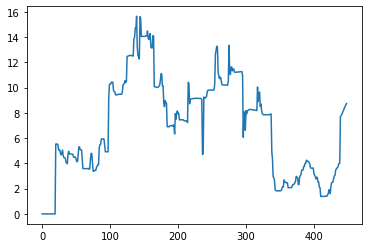

In [ ]:
plt.plot(df3)